<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/Experiment/Experiment_Gluonts_Pipeline_(2022_7_12).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install gluonts
!pip install mxnet-cu101

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 15.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 360.0 MB 18 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


# Experiment 

Data 1  original model

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import shutil
from datetime import datetime
from datetime import timedelta
# !pip uninstall pystan -y
# !pip install pystan~=2.14
# !pip install fbprophet
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
from numpy import mean
from numpy import std
# !pip install mxnet gluonts ujson
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.model.predictor import Predictor
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from datetime import datetime, date, time
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [5]:
!git clone https://github.com/andrasfe/ethgas.git

Cloning into 'ethgas'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 53 (delta 0), reused 2 (delta 0), pack-reused 50
Unpacking objects: 100% (53/53), done.


In [6]:
! unzip "/content/ethgas/data.zip" -d "/content/"

Archive:  /content/ethgas/data.zip
  inflating: /content/Binance_ETHUSDT_minute.csv  
  inflating: /content/Binance_MATICUSDT_minute.csv  
  inflating: /content/blocks.csv     
  inflating: /content/logs.csv       
  inflating: /content/token_transfers.csv  
  inflating: /content/traces.csv     
  inflating: /content/transactions.csv  


In [7]:
# load and clean data
import pandas as pd


def prepare_crypto_df(file_name):
    crypto_price_df = pd.read_csv(file_name, header=0, index_col=1)
    crypto_price_df = crypto_price_df[['close']]
    crypto_price_df.index.names = ['Date']
    crypto_price_df.columns = ['Count']
    return crypto_price_df


In [24]:
#loading data 
transactions = pd.read_csv('transactions.csv', header=0, index_col=0)
deep_ds = transactions.drop(['Value'], axis=1)
transaction_values = transactions.drop(['Price'], axis=1)
transaction_values.columns = ['Count']
ethprice = prepare_crypto_df('Binance_ETHUSDT_minute.csv')
maticprice = prepare_crypto_df('Binance_MATICUSDT_minute.csv')

In [9]:
ethprice

,Count
Date,
2021-11-27 01:35:00,4085.09
2021-11-27 01:34:00,4085.08
2021-11-27 01:33:00,4081.36
2021-11-27 01:32:00,4082.17
2021-11-27 01:31:00,4073.19
...,...
2019-11-27 07:49:00,146.00
2019-11-27 07:48:00,146.00
2019-11-27 07:47:00,146.00


In [10]:
pd.read_csv('blocks.csv', header=0, index_col=0)

,Count
Date,
2021-01-01 00:00:00,908
2021-01-01 00:01:00,848
2021-01-01 00:02:00,435
2021-01-01 00:03:00,637
2021-01-01 00:04:00,567
...,...
2021-10-18 23:55:00,685
2021-10-18 23:56:00,665
2021-10-18 23:57:00,949


In [11]:
pd.read_csv('traces.csv', header=0, index_col=0)

,Count
Date,
2021-01-01 00:00:00,131551972.0
2021-01-01 00:01:00,98746727.0
2021-01-01 00:02:00,88524927.0
2021-01-01 00:03:00,99669060.0
2021-01-01 00:04:00,66270427.0
...,...
2021-10-18 23:55:00,113310628.0
2021-10-18 23:56:00,97082817.0
2021-10-18 23:57:00,131466042.0


In [25]:
# features
features = list()
names = list()
features.append(ethprice)
names.append('ethprice')
# features.append(maticprice)
# names.append('maticprice')
features.append(transaction_values)
names.append('transaction_values')
features.append(pd.read_csv('blocks.csv', header=0, index_col=0))
names.append('blocks')
features.append(pd.read_csv('token_transfers.csv', header=0, index_col=0))
names.append('token_transfers')
features.append(pd.read_csv('traces.csv', header=0, index_col=0))
names.append('traces')
features.append(pd.read_csv('logs.csv', header=0, index_col=0))
names.append('logs')

In [26]:
def normalize_df(df):
  return (df - df.min()) / (df.max() - df.min())

In [27]:
ENABLE_FEATURES = True
RUN_MODEL = False
DELTA = 40
AGG = 20
FREQ = str(AGG) + 'min'

In [28]:
deep_ds.head()

,Price
Date,
2021-01-01 00:00:00,7.363430e+10
2021-01-01 00:01:00,6.615670e+10
2021-01-01 00:02:00,6.704984e+10
2021-01-01 00:03:00,7.918360e+10
2021-01-01 00:04:00,8.656393e+10


In [18]:
[i.shape for i in features]

[(1046863, 1), (415261, 1), (415288, 1), (415254, 1), (415288, 1), (415261, 1)]

In [29]:
# Aggre
#in order
deep_ds = deep_ds.sort_index()
deep_ds.index = pd.to_datetime(deep_ds.index)

deep_ds = deep_ds.groupby(pd.Grouper(level='Date', freq=FREQ)).mean()
end = deep_ds.index[-1]
deep_ds.head()

,Price
Date,
2021-01-01 00:00:00,8.084088e+10
2021-01-01 00:20:00,8.024579e+10
2021-01-01 00:40:00,7.701433e+10
2021-01-01 01:00:00,8.713914e+10
2021-01-01 01:20:00,7.425917e+10


In [21]:
deep_ds.index

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 00:20:00',
               '2021-01-01 00:40:00', '2021-01-01 01:00:00',
               '2021-01-01 01:20:00', '2021-01-01 01:40:00',
               '2021-01-01 02:00:00', '2021-01-01 02:20:00',
               '2021-01-01 02:40:00', '2021-01-01 03:00:00',
               ...
               '2021-10-18 20:40:00', '2021-10-18 21:00:00',
               '2021-10-18 21:20:00', '2021-10-18 21:40:00',
               '2021-10-18 22:00:00', '2021-10-18 22:20:00',
               '2021-10-18 22:40:00', '2021-10-18 23:00:00',
               '2021-10-18 23:20:00', '2021-10-18 23:40:00'],
              dtype='datetime64[ns]', name='Date', length=20952, freq='20T')

In [24]:
deep_ds.shape[0] - int(0.2*deep_ds.shape[0])

16762

In [25]:
deep_ds.index[16762]

Timestamp('2021-08-21 19:20:00', freq='20T')

## Create test

In [30]:
def cut_test(df:pd.DataFrame,
       test_rate:float=0.2,
       DELTA:int=40,
       AGG:int=20):
  test_cut = int(test_rate*df.shape[0])
  test_start = df.shape[0] - test_cut
  train_ds = df[:df.index[test_start]]
  start = df.index[df.shape[0] - test_cut + 1]
  end = df.index[-1] - timedelta(minutes=DELTA*AGG)
  test_ds = df[df.index[df.shape[0]-test_cut+1]:end]
  return start, end, train_ds, test_ds

In [31]:
start, end, train_ds, test_ds = cut_test(deep_ds)

(array([737791., 737822., 737850., 737881., 737911., 737942., 737972.,
        738003., 738034., 738064., 738095.]),
 <a list of 11 Text major ticklabel objects>)

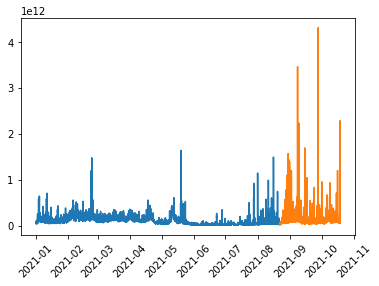

In [19]:
plt.plot(train_ds)
plt.plot(test_ds)
plt.xticks(rotation=45)

In [32]:
# Make training and test features

train_features = []
test_features = []

def fill_feature(reference_ds, feature):
    for date_entry in reference_ds.index:
        if not date_entry in feature.index:
            feature.loc[date_entry] = 0

In [22]:
features

[Date
 2021-01-01 00:00:00    0.168706
 2021-01-01 00:20:00    0.168250
 2021-01-01 00:40:00    0.168709
 2021-01-01 01:00:00    0.169715
 2021-01-01 01:20:00    0.170718
                          ...   
 2021-10-18 22:20:00    0.855756
 2021-10-18 22:40:00    0.858030
 2021-10-18 23:00:00    0.860523
 2021-10-18 23:20:00    0.861392
 2021-10-18 23:40:00    0.861845
 Freq: 20T, Name: Count, Length: 20952, dtype: float64, Date
 2021-01-01 00:00:00    0.033890
 2021-01-01 00:20:00    0.033887
 2021-01-01 00:40:00    0.010879
 2021-01-01 01:00:00    0.035850
 2021-01-01 01:20:00    0.013808
                          ...   
 2021-10-18 22:20:00    0.013703
 2021-10-18 22:40:00    0.006846
 2021-10-18 23:00:00    0.010218
 2021-10-18 23:20:00    0.021640
 2021-10-18 23:40:00    0.219369
 Freq: 20T, Name: Count, Length: 20952, dtype: float64, Date
 2021-01-01 00:00:00    0.224125
 2021-01-01 00:20:00    0.182474
 2021-01-01 00:40:00    0.197672
 2021-01-01 01:00:00    0.207709
 2021-01-01 01

In [33]:
test_cnt = int(0.2*deep_ds.shape[0])
test_start = deep_ds.shape[0] - test_cnt

#对原来的特征进行数据处理
#is a list
for i in range(len(features)):
    features[i]=features[i].sort_index()
    features[i].index = pd.to_datetime(features[i].index)
    features[i] = features[i][deep_ds.index[0]:deep_ds.index[-1]]
    if features[i].shape[0] != deep_ds.shape[0]:
        fill_feature(deep_ds, features[i])

    features[i] = features[i].groupby(pd.Grouper(level='Date', freq=FREQ)).mean()
    features[i] = features[i]["Count"]
    features[i] = normalize_df(features[i])
    train_features.append(features[i][:deep_ds.index[test_start]])
    test_features.append(features[i][features[i].index[deep_ds.shape[0] - test_cnt + 1]:end])

In [34]:
features

[Date
 2021-01-01 00:00:00    0.168706
 2021-01-01 00:20:00    0.168250
 2021-01-01 00:40:00    0.168709
 2021-01-01 01:00:00    0.169715
 2021-01-01 01:20:00    0.170718
                          ...   
 2021-10-18 22:20:00    0.855756
 2021-10-18 22:40:00    0.858030
 2021-10-18 23:00:00    0.860523
 2021-10-18 23:20:00    0.861392
 2021-10-18 23:40:00    0.861845
 Freq: 20T, Name: Count, Length: 20952, dtype: float64, Date
 2021-01-01 00:00:00    0.033890
 2021-01-01 00:20:00    0.033887
 2021-01-01 00:40:00    0.010879
 2021-01-01 01:00:00    0.035850
 2021-01-01 01:20:00    0.013808
                          ...   
 2021-10-18 22:20:00    0.013703
 2021-10-18 22:40:00    0.006846
 2021-10-18 23:00:00    0.010218
 2021-10-18 23:20:00    0.021640
 2021-10-18 23:40:00    0.219369
 Freq: 20T, Name: Count, Length: 20952, dtype: float64, Date
 2021-01-01 00:00:00    0.224125
 2021-01-01 00:20:00    0.182474
 2021-01-01 00:40:00    0.197672
 2021-01-01 01:00:00    0.207709
 2021-01-01 01

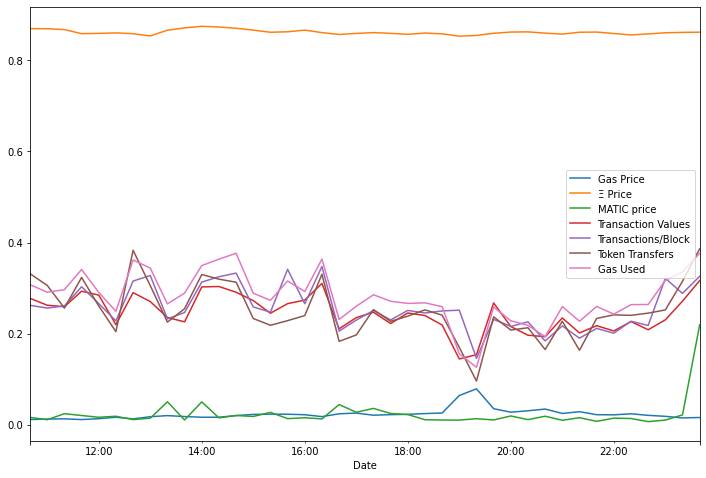

In [34]:
RANGE = DELTA
column_names = ['Gas Price', 'Ξ Price', 'MATIC price', 'Transaction Values', 'Transactions/Block', 'Token Transfers', 'Gas Used']
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ns = normalize_df(deep_ds)
correlation_df = pd.DataFrame(ns[-RANGE:])
correlation_df.columns = [column_names[0]]
ns[-RANGE:].plot(ax=ax)

#讲feature添加到correlation_df中
for i in range(len(features)):
    features[i][-RANGE:].plot(ax=ax)
    correlation_df[column_names[i + 1]] = features[i][-RANGE:]

# fig.suptitle('Normalized Feature Values', fontsize=20)

plt.legend(column_names, loc="best", prop={'size': 10})
plt.show()

In [40]:
correlation_df

,Gas Price,Ξ Price,MATIC price,Transaction Values,Transactions/Block,Token Transfers,Gas Used
Date,,,,,,,
2021-10-18 10:40:00,0.011420,0.869746,0.016219,0.277520,0.262286,0.331545,0.307600
2021-10-18 11:00:00,0.012522,0.869402,0.011035,0.262419,0.256096,0.305906,0.290872
2021-10-18 11:20:00,0.012977,0.867532,0.024311,0.259153,0.260802,0.256080,0.296579
2021-10-18 11:40:00,0.011433,0.858618,0.020285,0.293152,0.302951,0.323423,0.340828
2021-10-18 12:00:00,0.013335,0.859221,0.016433,0.284632,0.266011,0.260741,0.290497
2021-10-18 12:20:00,0.016492,0.860233,0.018638,0.219574,0.227918,0.204401,0.249121
2021-10-18 12:40:00,0.012884,0.858493,0.011336,0.289996,0.315413,0.383075,0.361724
2021-10-18 13:00:00,0.017650,0.853553,0.014385,0.270511,0.327631,0.305495,0.343954
2021-10-18 13:20:00,0.020046,0.866256,0.050407,0.235361,0.232369,0.225301,0.265303


In [35]:
df_corr = correlation_df.corr()
df_corr.to_latex('corr.tex', float_format='%.2f')
df_corr

,Gas Price,Ξ Price,MATIC price,Transaction Values,Transactions/Block,Token Transfers,Gas Used
Gas Price,1.000000,-0.441298,-0.143281,-0.708723,-0.516904,-0.708408,-0.773658
Ξ Price,-0.441298,1.000000,0.081790,0.485708,0.325694,0.394839,0.461708
MATIC price,-0.143281,0.081790,1.000000,0.320767,0.224258,0.342344,0.290561
Transaction Values,-0.708723,0.485708,0.320767,1.000000,0.792918,0.855414,0.924041
Transactions/Block,-0.516904,0.325694,0.224258,0.792918,1.000000,0.792345,0.881172
Token Transfers,-0.708408,0.394839,0.342344,0.855414,0.792345,1.000000,0.910394
Gas Used,-0.773658,0.461708,0.290561,0.924041,0.881172,0.910394,1.000000


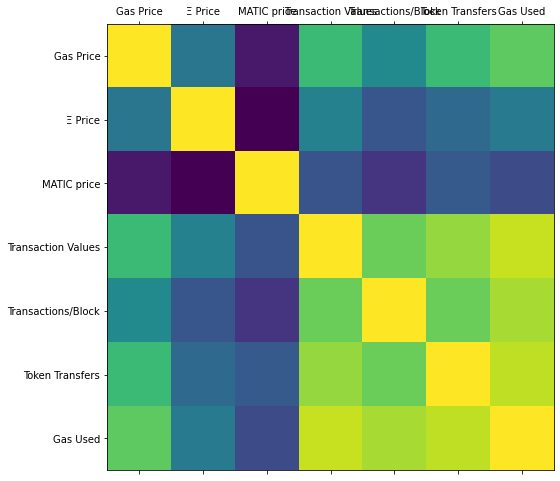

In [36]:
plt.figure(figsize=(8,8))
plt.matshow(df_corr.abs(), fignum=1)
ax = plt.gca()
ax.set_xticklabels([column_names] + column_names)
ax.set_yticklabels([column_names] + column_names)
plt.show()


In [ ]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
import typing

#多点可以参考这个
def build_dataset(
    frame: pd.DataFrame,
    target: str = 'Fatalities',
    cat_vars: typing.List[str] = ['Province/State'],
    real_vars: typing.List[str] = REAL_VARS
):
    return ListDataset(
        [
            {
                FieldName.START: df.index[0], 
                FieldName.TARGET: df[target].values,
                FieldName.FEAT_STATIC_CAT: df[cat_vars].values[0],
                FieldName.FEAT_STATIC_REAL: df[real_vars].values[0]
            }
            for g, df in frame.groupby(by=['Province/State'])
        ],
        freq = "D",
    )

In [43]:
train_features

[Date
 2021-01-01 00:00:00    0.168706
 2021-01-01 00:20:00    0.168250
 2021-01-01 00:40:00    0.168709
 2021-01-01 01:00:00    0.169715
 2021-01-01 01:20:00    0.170718
                          ...   
 2021-08-21 18:00:00    0.749902
 2021-08-21 18:20:00    0.748400
 2021-08-21 18:40:00    0.749732
 2021-08-21 19:00:00    0.746493
 2021-08-21 19:20:00    0.742066
 Freq: 20T, Name: Count, Length: 16763, dtype: float64, Date
 2021-01-01 00:00:00    0.033890
 2021-01-01 00:20:00    0.033887
 2021-01-01 00:40:00    0.010879
 2021-01-01 01:00:00    0.035850
 2021-01-01 01:20:00    0.013808
                          ...   
 2021-08-21 18:00:00    0.010031
 2021-08-21 18:20:00    0.004872
 2021-08-21 18:40:00    0.003841
 2021-08-21 19:00:00    0.028946
 2021-08-21 19:20:00    0.016251
 Freq: 20T, Name: Count, Length: 16763, dtype: float64, Date
 2021-01-01 00:00:00    0.224125
 2021-01-01 00:20:00    0.182474
 2021-01-01 00:40:00    0.197672
 2021-01-01 01:00:00    0.207709
 2021-01-01 01

In [38]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
import typing
dyn_features = [feature for feature in train_features]

In [39]:
dyn_features

[Date
 2021-01-01 00:00:00    0.168706
 2021-01-01 00:20:00    0.168250
 2021-01-01 00:40:00    0.168709
 2021-01-01 01:00:00    0.169715
 2021-01-01 01:20:00    0.170718
                          ...   
 2021-08-21 18:00:00    0.749902
 2021-08-21 18:20:00    0.748400
 2021-08-21 18:40:00    0.749732
 2021-08-21 19:00:00    0.746493
 2021-08-21 19:20:00    0.742066
 Freq: 20T, Name: Count, Length: 16763, dtype: float64, Date
 2021-01-01 00:00:00    0.033890
 2021-01-01 00:20:00    0.033887
 2021-01-01 00:40:00    0.010879
 2021-01-01 01:00:00    0.035850
 2021-01-01 01:20:00    0.013808
                          ...   
 2021-08-21 18:00:00    0.010031
 2021-08-21 18:20:00    0.004872
 2021-08-21 18:40:00    0.003841
 2021-08-21 19:00:00    0.028946
 2021-08-21 19:20:00    0.016251
 Freq: 20T, Name: Count, Length: 16763, dtype: float64, Date
 2021-01-01 00:00:00    0.224125
 2021-01-01 00:20:00    0.182474
 2021-01-01 00:40:00    0.197672
 2021-01-01 01:00:00    0.207709
 2021-01-01 01

In [51]:
training_data = ListDataset(
    [
     {'start':deep_ds.index[0],
      'target':train_ds['Price'],
      'feat_dynamic_real':dyn_features}
    ],freq=FREQ
)


In [43]:
feature_cnt = len(features) if ENABLE_FEATURES else 0 

In [50]:
dyn_features

[Date
 2021-01-01 00:00:00    0.168706
 2021-01-01 00:20:00    0.168250
 2021-01-01 00:40:00    0.168709
 2021-01-01 01:00:00    0.169715
 2021-01-01 01:20:00    0.170718
                          ...   
 2021-08-21 18:00:00    0.749902
 2021-08-21 18:20:00    0.748400
 2021-08-21 18:40:00    0.749732
 2021-08-21 19:00:00    0.746493
 2021-08-21 19:20:00    0.742066
 Freq: 20T, Name: Count, Length: 16763, dtype: float64, Date
 2021-01-01 00:00:00    0.033890
 2021-01-01 00:20:00    0.033887
 2021-01-01 00:40:00    0.010879
 2021-01-01 01:00:00    0.035850
 2021-01-01 01:20:00    0.013808
                          ...   
 2021-08-21 18:00:00    0.010031
 2021-08-21 18:20:00    0.004872
 2021-08-21 18:40:00    0.003841
 2021-08-21 19:00:00    0.028946
 2021-08-21 19:20:00    0.016251
 Freq: 20T, Name: Count, Length: 16763, dtype: float64, Date
 2021-01-01 00:00:00    0.224125
 2021-01-01 00:20:00    0.182474
 2021-01-01 00:40:00    0.197672
 2021-01-01 01:00:00    0.207709
 2021-01-01 01

In [ ]:

# dyn_features = [feature for feature in train_features]



# training_data = ListDataset(
#     [
#      {'start':deep_ds.index[0],
#       'target':train_ds['Price'],
#       'feat_dynamic_real':dyn_features}
#     ],freq=FREQ
# )

In [45]:

feature_cnt

6

In [60]:
import mxnet as mx
from gluonts.mx.distribution import LaplaceOutput
from gluonts.mx.distribution import NegativeBinomialOutput,ZeroInflatedNegativeBinomialOutput


model_path = "./pred_{}_{}_{}/".format(DELTA, AGG, feature_cnt)

def fit(RUN_MODEL:bool=True,
    ENABLE_FEATURES:bool=True):
  if RUN_MODEL:
      callbacks = [
          LearningRateReduction(objective="min",
                              patience=10,
                              base_lr=5e-3,
                              decay_factor=0.5,
                              ),
          ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
      ]

      estimator = DeepAREstimator(
          freq=FREQ,      
          prediction_length=DELTA,
          context_length=2*DELTA,
          num_layers = 6,
          num_cells = 120,
          use_feat_dynamic_real = ENABLE_FEATURES,
          cell_type='lstm',
          #distr_output=ZeroInflatedNegativeBinomialOutput(),#也不行
          distr_output=StudentTOutput()，
          #distr_output=LaplaceOutput(), 没有改进，反而更不行了
          dropout_rate=0.01,
          trainer=Trainer(ctx = mx.context.gpu(),
                          epochs=50,
                          callbacks=callbacks,
                          batch_size=64))

      predictor = estimator.train(training_data)
      if os.path.exists(model_path):
          shutil.rmtree(model_path)
      os.mkdir(model_path)
      predictor.serialize(Path(model_path))
  else:
      predictor = Predictor.deserialize(Path(model_path))
  return predictor

In [61]:
predict = fit()

100%|██████████| 50/50 [00:31<00:00,  1.58it/s, epoch=50/50, avg_epoch_loss=2.77]


In [63]:
end_date = datetime.combine(date(2021,10,17), time(6,0))
start_date = end_date - timedelta(10*AGG*DELTA) 
#test_ds = deep_ds[deep_ds.index[deep_ds.shape[0] - test_cnt + 1]:end]
test_ds = test_ds[start_date:end_date]['Price']
dyn_features = [feature[start_date:end_date] for feature in test_features]

In [64]:
test_data = ListDataset(
    [{"start": test_ds.index[0], "target": test_ds
    ,'feat_dynamic_real': dyn_features
    }],
    freq = FREQ
)

In [65]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predict,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

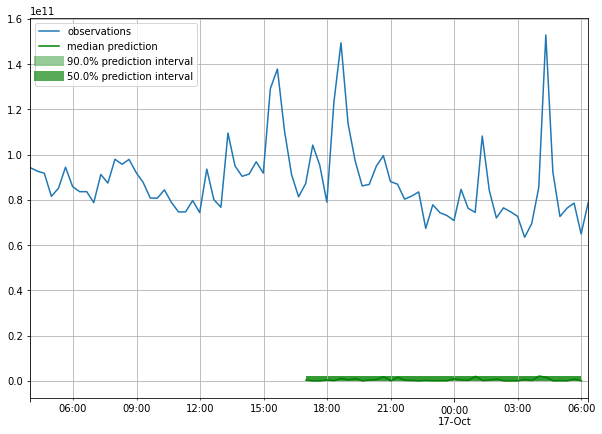

In [66]:
image_file = "pred_{}_{}_{}_{}.jpg".format(end_date, DELTA, AGG, feature_cnt)

def plot_prob_forecasts(ts_entry, forecast_entry, image_file):
    plot_length = 80
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.savefig(image_file, dpi=150, bbox_inches='tight')
    plt.show()
    

plot_prob_forecasts(tss[0], forecasts[0], image_file)